In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

In [2]:
import matplotlib as mpl
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


In [3]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
     
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [5]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [6]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [7]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [8]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [9]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [10]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, enc_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [11]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)

    dec_enc_mask = generate_padding_mask(src)

    dec_mask = generate_causality_mask(tgt.shape[-1])
    
    # 디코더 causal 마스크를 batch_size에 맞게 확장
    dec_mask = dec_mask[tf.newaxis, tf.newaxis, :, :]  # (1, 1, seq_len, seq_len)
    dec_mask = tf.tile(dec_mask, [tf.shape(src)[0], 1, 1, 1])

    return enc_mask, dec_enc_mask, dec_mask

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


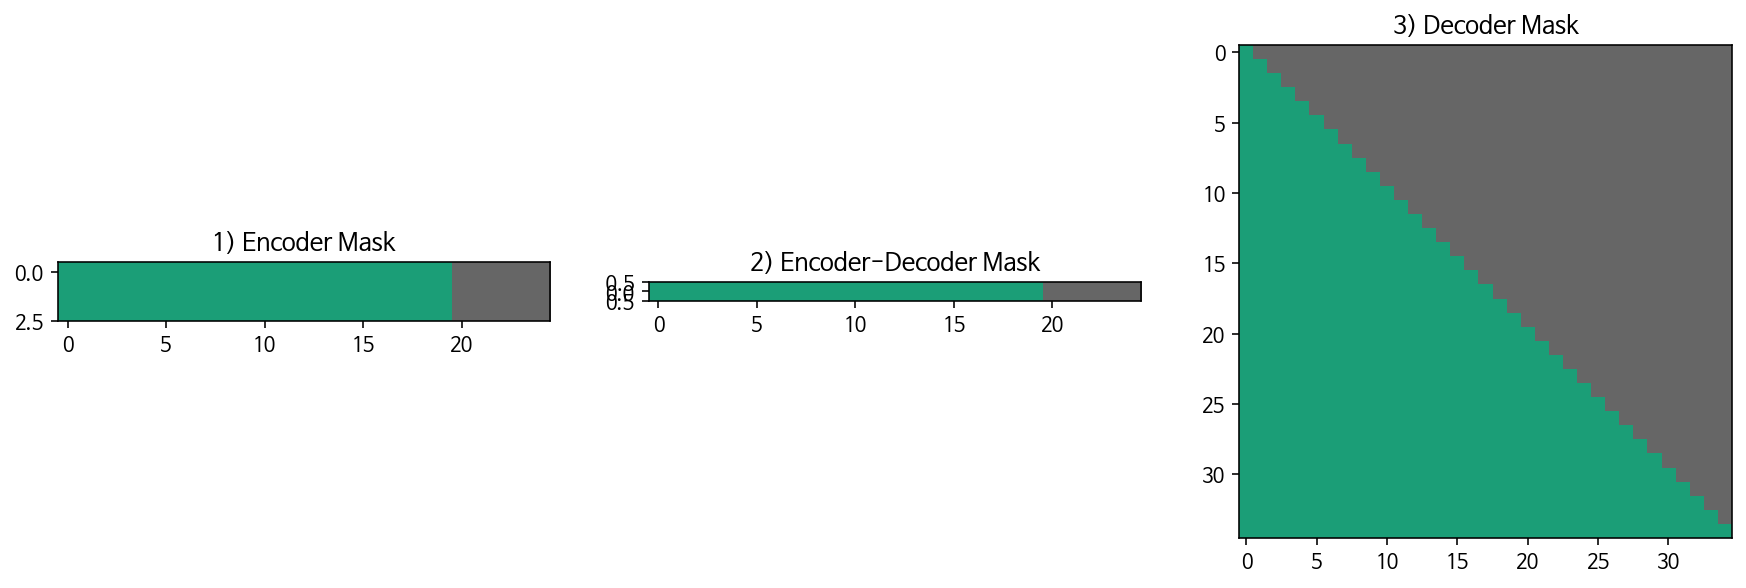

In [12]:
batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [13]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [14]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

In [15]:
# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    seen = set()  # 중복 제거를 위한 set
    cleaned_corpus = []

    with open(kor_path, "r", encoding="utf-8") as f_ko, \
    open(eng_path, "r", encoding="utf-8") as f_en:
        for k, e in zip(f_ko, f_en):  # 두 파일에서 동시에 한 줄씩 읽기
            k, e = k.strip(), e.strip()  # 앞뒤 공백 제거
            
            pair = f"{k}\t{e}"  # 탭으로 구분된 하나의 문자열로 저장
            if pair not in seen:
                seen.add(pair)
                cleaned_corpus.append(pair)  # 리스트에 추가

    return cleaned_corpus

In [16]:
cleaned_corpus = clean_corpus(kor_path, eng_path)

In [17]:
def preprocess_sentence(sentence):
    
    # 소문자화
    sentence = sentence.lower().strip()
    
    # 알파벳, 문장부호, 한글만 남기고 모두 제거
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣.,!?]", " ", sentence)
    
    # 문장부호 양옆에 공백 추가
    sentence = re.sub(r"([.,!?])", r" \1 ", sentence)
    
    # 문장 앞뒤의 불필요한 공백 제거
    sentence = re.sub(r"\s+", " ", sentence).strip()
    
    return sentence

In [18]:
import sentencepiece as spm

In [19]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    # 토크나이저 모델 저장할 경로 설정
    model_prefix = f"sp_tokenizer_{lang}"
    
    # corpus 파일 저장 (SentencePiece는 파일 입력을 요구함)
    corpus_file = f"{model_prefix}.txt"
    with open(corpus_file, "w", encoding="utf-8") as f:
        f.write("\n".join(corpus))
    
    # SentencePiece 학습
    spm.SentencePieceTrainer.train(
        input=corpus_file,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
        unk_id=unk_id,
        model_type="unigram"  # unigram 사용 (Unigram, char, word 가능)
    )
    
    # 학습된 모델 로드
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{model_prefix}.model")

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: sp_tokenizer_ko.txt
  input_format: 
  model_prefix: sp_tokenizer_ko
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces

True

uffix array...
unigram_model_trainer.cc(143) LOG(INFO) Extracting frequent sub strings...
unigram_model_trainer.cc(194) LOG(INFO) Initialized 82992 seed sentencepieces
trainer_interface.cc(526) LOG(INFO) Tokenizing input sentences with whitespace: 78929
trainer_interface.cc(537) LOG(INFO) Done! 44562
unigram_model_trainer.cc(489) LOG(INFO) Using 44562 sentences for EM training
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=34531 obj=9.86219 num_tokens=83351 num_tokens/piece=2.4138
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=25849 obj=8.00619 num_tokens=83808 num_tokens/piece=3.24221
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=21977 obj=7.92346 num_tokens=84668 num_tokens/piece=3.85257
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=1 size=21849 obj=7.90466 num_tokens=84909 num_tokens/piece=3.88617
trainer_interface.cc(615) LOG(INFO) Saving model: sp_tokenizer_en.model
trainer_interface.cc(626) LOG(INFO) Saving vocabs: sp_tokenizer_en.vocab


In [20]:
from tqdm.notebook import tqdm

In [21]:
# Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):

    ko_tokens = ko_tokenizer.encode(kor_corpus[idx])  # 토큰 리스트로 변환
    en_tokens = en_tokenizer.encode(eng_corpus[idx])

    if len(ko_tokens) <= 50 and len(en_tokens) <= 50:
        src_corpus.append(ko_tokens)
        tgt_corpus.append(en_tokens)
    
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78941 [00:00<?, ?it/s]

In [22]:
transformer = Transformer(
    n_layers = 4,
    d_ff = 512,
    src_vocab_size = SRC_VOCAB_SIZE,
    tgt_vocab_size = TGT_VOCAB_SIZE,
    d_model = 128,
    n_heads = 4,
    dropout = 0.3,
    pos_len=50)

In [23]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [25]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 기울기 계산
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # 기울기 적용하여 모델 파라미터 업데이트
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [26]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [27]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer, max_len=50):
    # 문장 전처리 (preprocess_sentence 함수가 정의되어 있다고 가정)
    sentence = preprocess_sentence(sentence)

    # 소스 문장 토크나이징
    pieces = src_tokenizer.encode_as_pieces(sentence)  # 토큰 문자열 리스트
    tokens = src_tokenizer.encode_as_ids(sentence)     # 토큰 ID 리스트

    # 입력 패딩 (enc_train의 최대 길이에 맞춤)
    _input = tf.keras.preprocessing.sequence.pad_sequences(
        [tokens], maxlen=max_len, padding='post', value=src_tokenizer.pad_id()
    )  # (1, max_len)

    # 출력 초기화: BOS 토큰으로 시작
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)  # (1, 1)
    ids = []

    # Attention 가중치 저장
    enc_attns, dec_attns, dec_enc_attns = [], [], []

    # 디코더 예측 루프
    for _ in range(max_len):
        # 마스크 생성
        enc_padding_mask = generate_padding_mask(_input)  # (1, 1, 1, src_len)
        dec_padding_mask = generate_padding_mask(output)  # (1, 1, 1, tgt_len)
        combined_mask = tf.maximum(
            dec_padding_mask,
            generate_causality_mask(tf.shape(output)[1])
        )  # (1, 1, tgt_len, tgt_len)

        # 모델 예측
        predictions, enc_attns_t, dec_attns_t, dec_enc_attns_t = model(
            _input,
            output,
            enc_padding_mask,
            combined_mask,
            enc_padding_mask
        )

        # 마지막 토큰에 대한 예측 ID
        predicted_id = int(tf.argmax(predictions[:, -1, :], axis=-1).numpy()[0])  # 스칼라 값
        print(f"predicted_id type: {type(predicted_id)}, value: {predicted_id}")

        # EOS 토큰이면 종료
        if predicted_id == tgt_tokenizer.eos_id():
            print(f"ids before decode: {ids}, types: {[type(x) for x in ids]}")
            result = tgt_tokenizer.decode_ids(ids)
            
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        # 예측된 ID 추가
        ids.append(predicted_id)
        output = tf.concat([output, [[predicted_id]]], axis=-1)  # (1, tgt_len+1)

        # Attention 가중치 저장
        enc_attns.append(enc_attns_t)
        dec_attns.append(dec_attns_t)
        dec_enc_attns.append(dec_enc_attns_t)

    # 최대 길이에 도달한 경우
    print(f"ids after loop: {ids}, types: {[type(x) for x in ids]}")
    result = tgt_tokenizer.decode_ids(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [28]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [29]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_8521/2719091706.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 2
ids before decode: [5], types: [<class 'int'>]
Input: 오바마는 대통령이다.
Predicted translation: .
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 2
ids before decode: [5], types: [<class 'int'>]
Input: 시민들은 도시 속에 산다.
Predicted translation: .
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 2
ids before decode: [5], types: [<class 'int'>]
Input: 커피는 필요 없다.
Predicted translation: .
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 2
ids before decode: [5, 5, 5], types: [<class 'int'>, <class 'int'>, <class 'int'>]
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: . . .


  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 2
ids before decode: [131, 131, 131, 131, 131, 131, 131, 5], types: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]
Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama obama .
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 2
ids before decode: [131, 131, 131, 131, 131, 131, 5], types: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]
Input: 오바마는 대통령이다.
Predicted translation: obama obama obama obama obama obama .
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 4
predicted_

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 2
ids before decode: [67, 67, 67], types: [<class 'int'>, <class 'int'>, <class 'int'>]
Input: 오바마는 대통령이다.
Predicted translation: president president president
predicted_id type: <class 'int'>, value: 2
ids before decode: [], types: []
Input: 시민들은 도시 속에 산다.
Predicted translation: 
predicted_id type: <class 'int'>, value: 2
ids before decode: [], types: []
Input: 커피는 필요 없다.
Predicted translation: 
predicted_id type: <class 'int'>, value: 82
predicted_id type: <class 'int'>, value: 82
predicted_id type: <class 'int'>, value: 82
predicted_id type: <class 'int'>, value: 82
predicted_id type: <class 'int'>, value: 82
predicted_id type: <class 'int'>, value: 82
predicted_id type: <class 'int'>, value: 82
predicted_id type: <class 'int'>, value: 297
predicted_id type: <class 'int'>, value: 30
predicted_id type: <class 'int

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 148
predicted_id type: <class 'int'>, value: 15
predicted_id type: <class 'int'>, value: 15
predicted_id type: <class 'int'>, value: 15
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 2
ids before decode: [67, 67, 67, 148, 15, 15, 15, 5], types: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]
Input: 오바마는 대통령이다.
Predicted translation: president president president bush s s s .
predicted_id type: <class 'int'>, value: 13
predicted_id type: <class 'int'>, value: 13
predicted_id type: <class 'int'>, value: 13
predicted_id type: <class 'int'>, value: 13
predicted_id type: <class 'int'>, value: 13
predicted_id type: <class 'int'>, value: 13
predicted_id type: <class 'int'>, value: 13
predicted_id type: <class 'int'

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 148
predicted_id type: <class 'int'>, value: 148
predicted_id type: <class 'int'>, value: 148
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 113


  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 148
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
pred

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 148
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 2
ids before decode: [67, 67, 67, 67, 67, 67, 67, 148, 5], types: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]
Input: 오바마는 대통령이다.
Predicted translation: president president president president president president president bush .
predicted_id type: <class 'int'>, value: 13
predicted_id type: <class 'int'>, value: 13
predicted_id type: <class 'int'>, value: 13
predicted_id type: <class 'int'>, value: 13
predicted_id type: <class 'int'>, value: 13
predicted_id type: <cl

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 148
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 1051
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 2


  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 783
predicted_id type: <class 'int'>, value: 783
predicted_id type: <class 'int'>, value: 783
predicted_id type: <class 'int'>, value: 783
predicted_id type: <class 'int'>, value: 783
predicted_id type: <class 'int'>, value: 783
predicted_id type: <class 'int'>, value: 783
predicted_id type: <class 'int'>, 

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 720
predicted_id type: <class 'int'>, value: 720
predicted_id type: <class 'int'>, value: 720
predicted_id type: <class 'int'>, value: 720
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 193
predicted_id type: <class 'int'>, value: 193
predicted_id type: <class 'int'>, value: 193
predicted_id type: <class 'int'>, value: 193
predicted_id type: <class 'int'>, value: 193
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predic

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predict

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 792
predicted_id type: <class 'int'>, value: 792
predicted_id type: <class 'int'>, value: 792
predicted_id type: <class 'int'>, value: 18
predicted_id type: <class 'int'>, value: 4
predicted_id type: <class 'int'>, value: 169
predicted_id type: <class 'int'>, value: 169
predicted_id type: <class 'int'>, value: 1386
predicted_id type: <class 'int'>, value: 1386
predicted_id type: <class 'int'>, value: 1386
predicted_id type: <class 'int'>, value: 1386
predicted_id type: <class 'int'>, value: 1386
predicted_id type: <class 'int'>, value: 792
predicted_id type: <class 'int'>, value: 7
predicted_id type: <class 'int'>, value: 34
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 2
ids before decode: [792, 792, 792, 18, 4, 169, 169, 1386, 1386, 1386, 1386, 1386, 792, 7, 34, 67, 5], types: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 158
predicted_id type: <class 'int'>, value: 351
predicted_id type: <class 'int'>, value: 351
predicted_id type: <class 'int'>, value: 351
predicted_id type: <class 'int'>, value: 351
predicted_id type: <class 'int'>, value: 351
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 3507
predicted_id type: <class 'int'>, value: 3507
predicted_id type: <class 'int'>, value: 117
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'in

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 131
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 1839
predicted_id type: <class 'int'>, value: 1839
predicted_id type: <class 'int'>, value: 1839
predicted_id type: <class 'int'>, value: 1839
predicted_id type: <class 'int'>, value: 1839
predicted_id type: <class 'int'>, value: 1839
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 2
ids before decode: [67, 67, 67, 67, 67, 67, 131, 6, 1839, 1839, 1839, 1839, 1839, 1839, 5], types: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predict

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 67
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 6
predicted_id type: <class 'int'>, value: 65
predicted_id type: <class 'int'>, value: 65
predicted_id type: <class 'int'>, value: 65
predicted_id type: <class 'int'>, value: 65
predicted_id type: <class 'int'>, value: 65
predicted_id type: <class 'int'>, value: 65
predicted_id type: <class 'int'>, value: 65
predicted_id type: <class 'int'>, value: 

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 256
predicted_id type: <class 'int'>, value: 256
predicted_id type: <class 'int'>, value: 256
predicted_id type: <class 'int'>, value: 256
predicted_id type: <class 'int'>, value: 256
predicted_id type: <class 'int'>, value: 256
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 2

  0%|          | 0/1127 [00:00<?, ?it/s]

predicted_id type: <class 'int'>, value: 256
predicted_id type: <class 'int'>, value: 256
predicted_id type: <class 'int'>, value: 256
predicted_id type: <class 'int'>, value: 256
predicted_id type: <class 'int'>, value: 256
predicted_id type: <class 'int'>, value: 256
predicted_id type: <class 'int'>, value: 256
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 5
predicted_id type: <class 'int'>, value: 2
ids before decode: [256, 256, 256, 256, 

In [31]:
text = '오늘은 밥이 맛없는거 같아'

In [34]:
translate(text, transformer, ko_tokenizer, en_tokenizer, plot_attention=False)

predicted_id type: <class 'int'>, value: 846
predicted_id type: <class 'int'>, value: 846
predicted_id type: <class 'int'>, value: 846
predicted_id type: <class 'int'>, value: 8
predicted_id type: <class 'int'>, value: 8
predicted_id type: <class 'int'>, value: 322
predicted_id type: <class 'int'>, value: 2
ids before decode: [846, 846, 846, 8, 8, 322], types: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]
Input: 오늘은 밥이 맛없는거 같아
Predicted translation: problem problem problem to to health


### 결론
- 학습과정 중간 중간에 의미있는 단어들을 출력하는 경우가 있음
- 하지만 동일한 단어가 반복되는 케이스가 훨씬 많았음
- 단어 반복할 경우 패널티를 주는 방법과 소프트맥스온도를 적용해 볼 예정